##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
display(df.head(20))

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


In [8]:
df.agg([min, max]).T

C:\Users\ryl3r\AppData\Local\Temp\ipykernel_4332\2714415846.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df.agg([min, max]).T
C:\Users\ryl3r\AppData\Local\Temp\ipykernel_4332\2714415846.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df.agg([min, max]).T


,min,max
X,-116.000000,-114.62557
Y,35.068419,37.00000
Area_Command,0.000000,11.00000
NIBRSOffenseCode,0.000000,2.00000
DayOfWeek,0.000000,6.00000
Time,0.000000,23.00000
VictimCount,0.000000,6.00000


input variables:
- X, Y = coordinates
- Area_Command = command area
- NIBRSOffenseCode = offense code
- DayOfWeek = day of the week
- Time = time of accident

output variables:
- VictimCount = number of victims

Since this is a regression model, there is no need to normalize the data, as it wouldn't play a big factor in accuracy.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

input_columns = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
target_column = df['VictimCount']

X_tensor = torch.tensor(input_columns.values, dtype=torch.float32)
y_tensor = torch.tensor(target_column.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=40)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Printing data
for inputs, targets in train_loader:
    print("Input Batch Shape:", inputs.shape)
    print("Target Batch Shape:", targets.shape)
    break

Input Batch Shape: torch.Size([40, 6])
Target Batch Shape: torch.Size([40])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [10]:
criterion = torch.nn.MSELoss()

class RegressionModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = RegressionModel(input_size=X_tensor.shape[1], hidden_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# recording max accuracy
max_epoch = 0
max_accuracy = 0

# set value for epoch
num_epochs = 200  
for epoch in range(num_epochs):
    model.train()

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs_val, targets_val in test_loader:
            outputs_val = model(inputs_val)
            _, predicted = torch.max(outputs_val.data, 1)
            total += targets_val.size(0)
            correct += (predicted == targets_val).sum().item()
            mse = criterion(outputs_val, targets_val)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, mse: {mse.item()}, Accuracy: {accuracy}%')

c:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.red

Epoch 1/200, Loss: 18.217227935791016, mse: 8.201674461364746, Accuracy: 56.36363636363637%
Epoch 2/200, Loss: 4.6217451095581055, mse: 8.262826919555664, Accuracy: 56.36363636363637%
Epoch 3/200, Loss: 12.159863471984863, mse: 11.146967887878418, Accuracy: 56.36363636363637%
Epoch 4/200, Loss: 4.081509590148926, mse: 1.8724004030227661, Accuracy: 56.36363636363637%
Epoch 5/200, Loss: 2.6721270084381104, mse: 2.458303689956665, Accuracy: 56.36363636363637%
Epoch 6/200, Loss: 2.675069808959961, mse: 2.3131823539733887, Accuracy: 56.36363636363637%
Epoch 7/200, Loss: 1.6399937868118286, mse: 1.1339542865753174, Accuracy: 56.36363636363637%
Epoch 8/200, Loss: 1.1242151260375977, mse: 1.5736286640167236, Accuracy: 56.36363636363637%
Epoch 9/200, Loss: 0.7677662372589111, mse: 1.2913738489151, Accuracy: 56.36363636363637%
Epoch 10/200, Loss: 1.011746883392334, mse: 1.133906602859497, Accuracy: 56.36363636363637%
Epoch 11/200, Loss: 0.7349717617034912, mse: 1.1466244459152222, Accuracy: 56.3

I couldn't figure why the accuracy percentage remained constant throughout the training session despipte other variables changing.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Since this is a classification model, we need to normalize the data
normalized_input = StandardScaler().fit_transform(input_columns)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(normalized_input, target_column, test_size=0.2, random_state=40)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 40
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = ClassificationModel(input_size=X_tensor.shape[1], hidden_size=64, num_classes=target_column.nunique())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# recording max accuracy
max_epoch = 0
max_accuracy = 0.0

# set value for epoch
num_epochs = 200  
for epoch in range(num_epochs):
    model.train()

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs_val, targets_val in test_loader:
            outputs_val = model(inputs_val)
            _, predicted = torch.max(outputs_val.data, 1)
            total += targets_val.size(0)
            correct += (predicted == targets_val).sum().item()
            mse = criterion(outputs_val, targets_val)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, mse: {mse.item()}, Accuracy: {accuracy}%')

Epoch 1/200, Loss: 1.953329086303711, mse: 1.961946725845337, Accuracy: 12.727272727272727%
Epoch 2/200, Loss: 1.941153883934021, mse: 1.9479986429214478, Accuracy: 25.454545454545453%
Epoch 3/200, Loss: 1.9141159057617188, mse: 1.9329768419265747, Accuracy: 34.54545454545455%
Epoch 4/200, Loss: 1.909841775894165, mse: 1.9169671535491943, Accuracy: 45.45454545454545%
Epoch 5/200, Loss: 1.9173475503921509, mse: 1.9000188112258911, Accuracy: 47.27272727272727%
Epoch 6/200, Loss: 1.873590111732483, mse: 1.8823127746582031, Accuracy: 45.45454545454545%
Epoch 7/200, Loss: 1.8318411111831665, mse: 1.8641873598098755, Accuracy: 43.63636363636363%
Epoch 8/200, Loss: 1.8547537326812744, mse: 1.8454780578613281, Accuracy: 47.27272727272727%
Epoch 9/200, Loss: 1.8178834915161133, mse: 1.8273342847824097, Accuracy: 49.09090909090909%
Epoch 10/200, Loss: 1.8420482873916626, mse: 1.8095557689666748, Accuracy: 50.90909090909091%
Epoch 11/200, Loss: 1.733947515487671, mse: 1.7928354740142822, Accuracy

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

The regression model seems to be overall more accurate, with a much lower MSE. While the classification model sometimes have higher accuracy. This is most like because the regression model is good at predicting the average number of victims, which is 0 to 1, but once the number of victims climb higher, the classification model works better.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


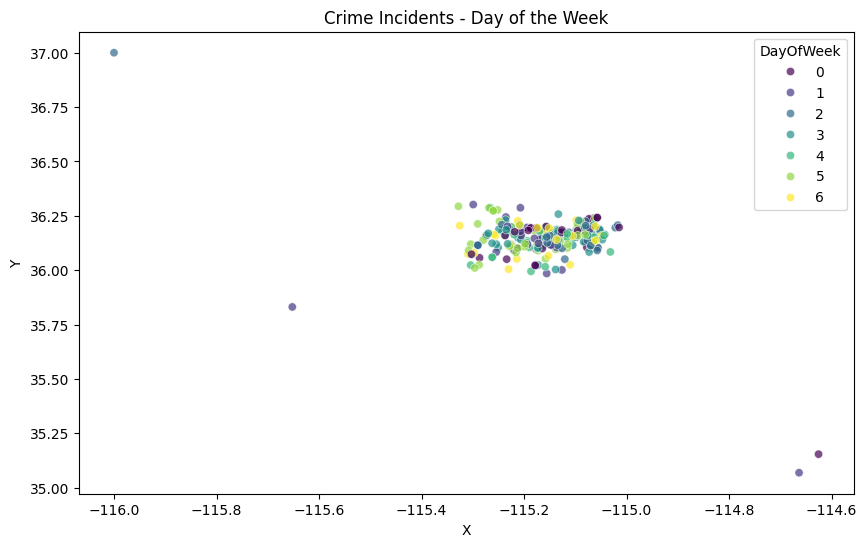

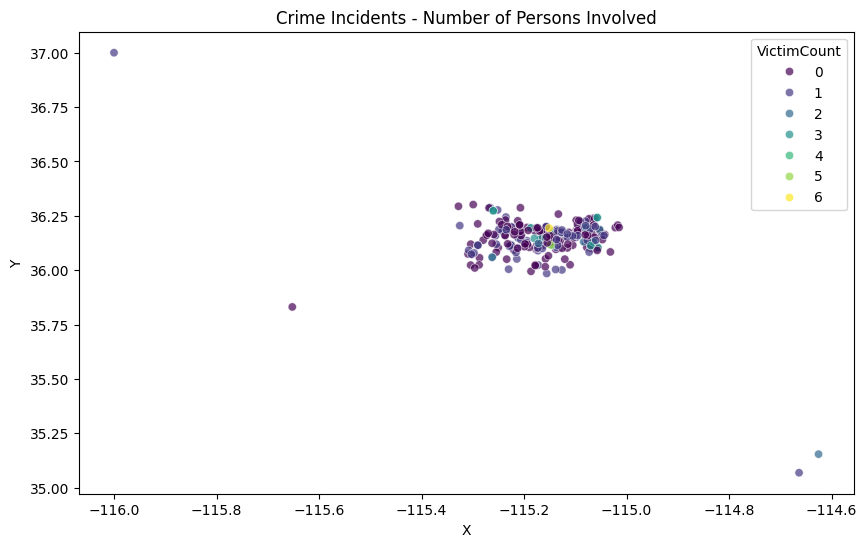

Most Frequent Day(s) in Descending Order: Index([4, 3, 5, 0, 1, 2, 6], dtype='int64', name='DayOfWeek')


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of day of the week
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X', y='Y', hue='DayOfWeek', data=df, palette='viridis', alpha=0.7)
plt.title('Crime Incidents - Day of the Week')
plt.show()

# Scatter plot of the number of persons involved
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X', y='Y', hue='VictimCount', data=df, palette='viridis', alpha=0.7)
plt.title('Crime Incidents - Number of Persons Involved')
plt.show()

# Sorting the number of crimes reported by the day of the week
crime_count_by_day = df['DayOfWeek'].value_counts().sort_index()

# Displaying the most frequent days
days = crime_count_by_day.sort_values(ascending=False).index
print("Most Frequent Day(s) in Descending Order:", days)


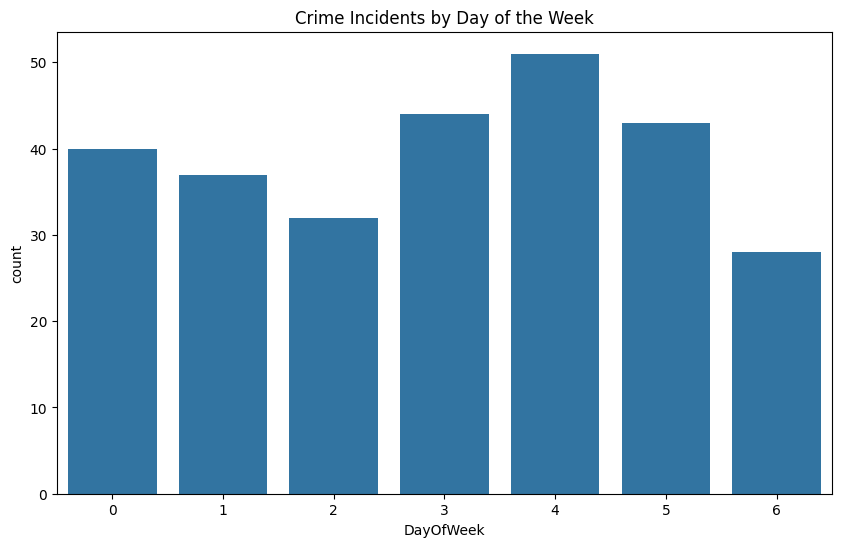

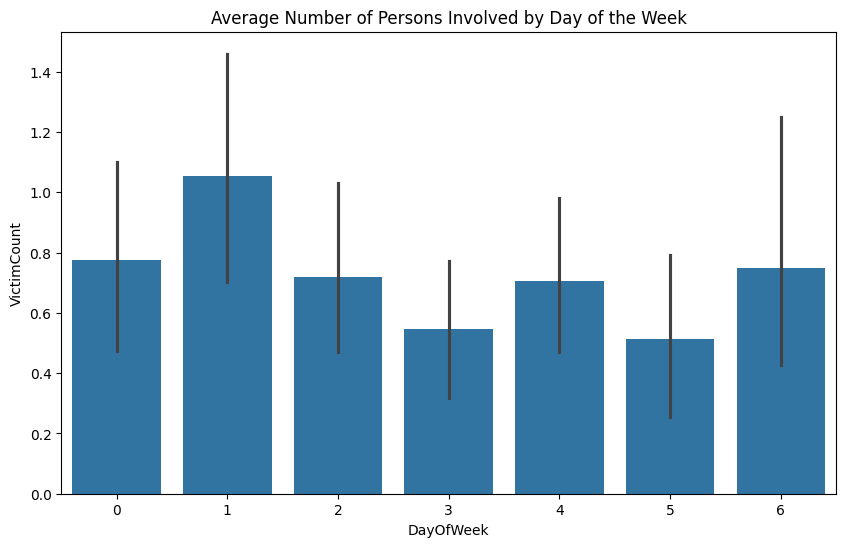

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


# Bar chart with color indicating the day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=df)
plt.title('Crime Incidents by Day of the Week')
plt.show()

# Bar chart with color indicating the number of persons involved
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='VictimCount', data=df)
plt.title('Average Number of Persons Involved by Day of the Week')
plt.show()


Most of the crimes are crowded into one location which we can assume is an urban area with high population density. Looking up the coordinates of this dense spot points to Las Vegas, which confirms our suspicion. There are higher crime counts on days 4 and 3, which could indicate it being weekends. Most of the crimes involve 0 to 1 victims which indicates small crime.